In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Notebook_imports import *
import random
from collections import Counter
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})
import pandas as pd
import numpy as np
import os

from ipywidgets import interact
import ipywidgets as widgets
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from src.utils.Utils_io import Console_and_file_logger, ensure_dir
from src.visualization.Visualize import plot_3d_vol, plot_4d_vol, plot_value_histogram, my_autopct
from src.data.Dataset import get_metadata_maybe, filter_4d_vol, copy_meta_and_save, create_3d_volumes_from_4d_files, describe_sitk, describe_volume, describe_path
from src.data.Dataset import split_one_4d_sitk_in_list_of_3d_sitk
from src.data.Dataset import copy_meta_and_save, get_patient
from src.data.Preprocess import resample_3D
Console_and_file_logger('tests_temp_resampling', logging.INFO)

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models


2022-01-11 10:46:41,108 INFO -------------------- Start --------------------
2022-01-11 10:46:41,109 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2022-01-11 10:46:41,109 INFO Log file: ./logs/tests_temp_resampling.log
2022-01-11 10:46:41,109 INFO Log level for console: INFO


In [2]:
from ipyfilechooser import FileChooser
path_chooser = FileChooser(os.path.join(os.getcwd(),'/mnt/ssd/data/gcn/02_imported_4D_unfiltered/'), '')
display(path_chooser)

FileChooser(path='/mnt/ssd/data/gcn/02_imported_4D_unfiltered', filename='', title='HTML(value='', layout=Layo…

In [15]:
img_path = path_chooser.selected
path_ = os.path.join(img_path, '*img.nrrd')
files_ = sorted(glob.glob(path_))
print(len(files_))

1390


In [16]:
path_ = os.path.join(img_path, '*msk.nrrd')
masks = sorted(glob.glob(path_))
print(len(masks))

1390


In [17]:
from src.visualization.Visualize import show_2D_or_3D
@interact
def show(i = (0,len(files_)-1)):
    global img, msk
    img = sitk.GetArrayFromImage(sitk.ReadImage(files_[i]))
    msk = sitk.GetArrayFromImage(sitk.ReadImage(masks[i]))
    show_2D_or_3D(img, msk)

interactive(children=(IntSlider(value=694, description='i', max=1389), Output()), _dom_classes=('widget-intera…

In [19]:
import matplotlib.pyplot as plt
from src.visualization.Visualize import show_2D_or_3D
from src.data.Preprocess import *

(15, 256, 256)


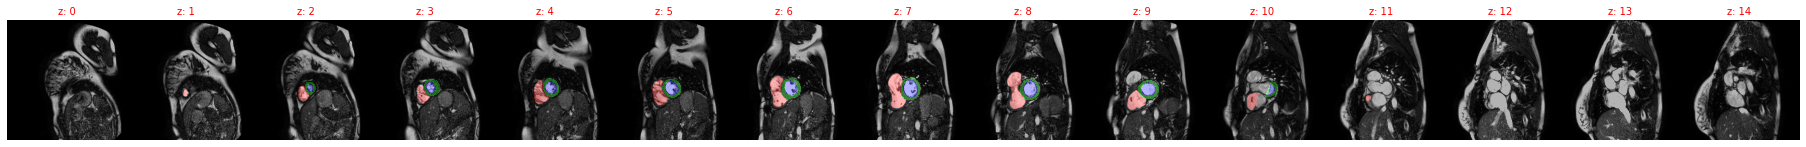

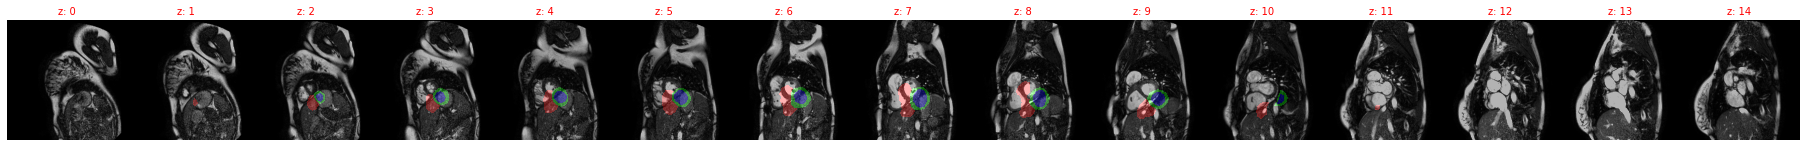

In [25]:
show_2D_or_3D(img, msk)
msk_ = np.roll(msk, 20, axis=(-2,-1))
show_2D_or_3D(img, msk_)
print(img.shape)

256 256
[130 150]
-2 -22


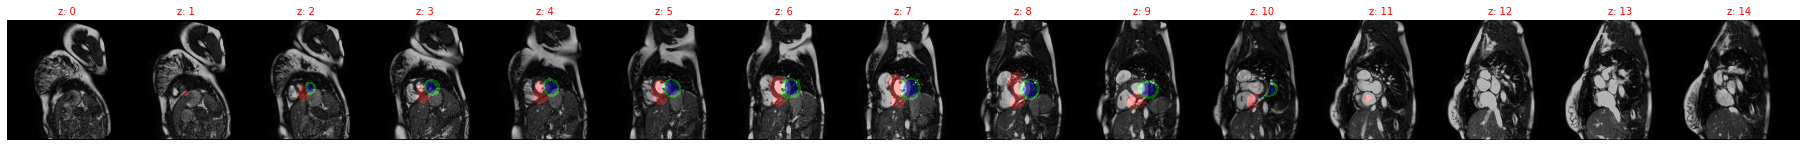

In [29]:
# roll to center
# find the new mean septum center
fips, sips = get_ip_from_mask_3d(msk)
# average both points to find the mean fip and sip
fip = np.array(fips).mean(axis=0)
sip = np.array(sips).mean(axis=0)
center = np.mean([fip,sip], axis=0).astype(int)
ny, nx = img.shape[-2:]
ry = int(ny//2-center[0])
rx = int(nx // 2 - center[1])
img_ = np.roll(img, ry, axis=-2)
img_ = np.roll(img_, rx, axis=-1)
show_2D_or_3D(img_, msk)
print(ny, nx)
print(center)
print(ry, rx)

In [8]:
# Get the first and second insertion points for all valid slices
fips, sips = get_ip_from_mask_3d(mask3d)
# average both points to find the mean fip and sip
fip = np.array(fips).mean(axis=0)
sip = np.array(sips).mean(axis=0)
# Calc the angle to the x-axis
ip_angle = get_angle2x(fip, sip)
# How much do we want to rotate
rot_angle = ip_angle - 90

# Rotate the 4D volume in-plane (x,y-axis)
model_inputs = ndimage.rotate(model_inputs, angle=rot_angle, reshape=False, order=1, axes=(-2, -1))
mask3d = ndimage.rotate(mask3d, angle=rot_angle, reshape=False, order=1, axes=(-2, -1))

# roll to center
# find the new mean septum center
fips, sips = get_ip_from_mask_3d(mask3d)
# average both points to find the mean fip and sip
fip = np.array(fips).mean(axis=0)
sip = np.array(sips).mean(axis=0)
center = np.mean([fip,sip], axis=0).astype(int)
ny, nx = model_inputs.shape[2:]
ry = int(ny//2-center[0])
rx = int(nx // 2 - center[1])
model_inputs = np.roll(model_inputs, ry, axis=-2)
model_inputs = np.roll(model_inputs, rx, axis=-1)

SyntaxError: invalid syntax (<ipython-input-8-2031e46cc23f>, line 3)

In [4]:
example = 0
temp_f = files_[example]
sitk_img = sitk.ReadImage(temp_f)
info(sitk_img.GetSize())
info(sitk_img.GetSpacing())

2021-04-21 17:09:15,640 INFO (138, 192, 10, 14)
2021-04-21 17:09:15,641 INFO (1.7708333333333, 1.7708333333333, 8.8, 45.0)


In [12]:
@interact_manual
def resample_vol_along_t(example=(0,len(files_)-1), 
                          t_spacing=(5,55),
                         int_img=[sitk.sitkNearestNeighbor, sitk.sitkLinear,sitk.sitkBSpline,sitk.sitkGaussian],
                         int_msk=[sitk.sitkNearestNeighbor, sitk.sitkLinear,sitk.sitkBSpline,sitk.sitkLabelGaussian],
                         plot_vol=False,
                         plot_hist=False,
                         save_=False,
                        export_dir='/mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax_t_res_18'):
    global resampled
    
    temp_f = files_[example]
    info(example)
    info(temp_f)
    temp_msk_f = temp_f.replace('clean', 'mask')
    sitk_img = sitk.ReadImage(temp_f)
    sitk_msk = sitk.ReadImage(temp_msk_f)
    from src.data.Preprocess import resample_t_of_4d
    
    resampled_cmr_sitk = resample_t_of_4d(sitk_img, t_spacing=t_spacing,interpolation=int_img, ismask=False)
    resampled_cmr_sitk = resample_t_of_4d(sitk_msk, t_spacing=t_spacing,interpolation=int_msk, ismask=True)
    
    patient = get_patient(temp_f)
    cmr_export_f = '{}_clean.nrrd'.format(patient)
    msk_export_f = '{}_mask.nrrd'.format(patient)
    if save_:
        ensure_dir(export_dir)
        sitk.WriteImage(resampled_cmr_sitk, os.path.join(export_dir, cmr_export_f))
        sitk.WriteImage(resampled_msk_sitk, os.path.join(export_dir, msk_export_f))
    else:
        return resampled_cmr_sitk

interactive(children=(IntSlider(value=139, description='example', max=278), IntSlider(value=30, description='t…

In [17]:
%%timeit
# resample the temporal ais of all 4D volumes
params = {
    't_spacing':18,
    'int_img':sitk.sitkLinear,
    'int_msk':sitk.sitkNearestNeighbor,
    'plot_vol':False,
    'plot_hist':False,
    'save_':False,
    'export_dir':'/mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax_t_res_18'
}

list(map(lambda x : resample_vol_along_t(example=x, **params), range(10)))

2021-04-22 14:30:07,492 INFO 0
2021-04-22 14:30:07,493 INFO /mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/0000-02z1l14n_2006-11-09_volume_clean.nrrd
2021-04-22 14:30:07,603 INFO 1
2021-04-22 14:30:07,604 INFO /mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/0000-04nejquz_2007-03-13_volume_clean.nrrd
2021-04-22 14:30:08,174 INFO 2
2021-04-22 14:30:08,175 INFO /mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/0000-0ae4r74l_1900-01-01_volume_clean.nrrd
2021-04-22 14:30:08,298 INFO 3
2021-04-22 14:30:08,299 INFO /mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/0000-0hqqw4zn_2007-05-23_volume_clean.nrrd
2021-04-22 14:30:08,664 INFO 4
2021-04-22 14:30:08,665 INFO /mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/0000-0ptv75mp_2005-06-27_volume_clean.nrrd
2021-04-22 14:30:08,957 INFO 5
2021-04-22 14:30:08,957 INFO /mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/0000-0rpellu8_2007-02-13_volume_clean.nrrd
2021-04-22 14:30:09,746 INFO 6
2021-04-22 14:30:09,747 INFO /mnt/ssd/data/gcn/02_imported_4D_u

5 s ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# tests with itk

In [21]:
itk.Image[itk.Vector[itk.D,3], 3]

itk.itkImagePython.itkImageVD33

In [1]:
import itk
from itk import Strain
import numpy as np

In [3]:
import itk
from itk import Strain
import numpy as np
# Some random data for the example. In practice, you can use the output of an image registration.
Dimension = 3
a = np.random.random((3,64,64,64))
print(a.dtype)
DisplacementImageType = itk.Image[itk.Vector[itk.D,3],3]
displacement = itk.image_view_from_array(a, ttype=DisplacementImageType)
strain_filter = itk.StrainImageFilter[DisplacementImageType, itk.D, itk.D].New(displacement)
strain_filter.Update()
strain = strain_filter.GetOutput()

float64


In [7]:
nda = itk.GetArrayFromImage(strain)

In [8]:
nda.shape

(3, 64, 64, 6)

In [10]:
import matplotlib.pyplot as plt

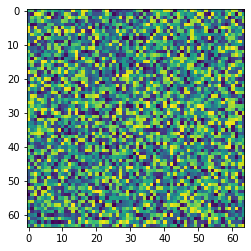

In [14]:
plt.imshow(a[0,...,0])

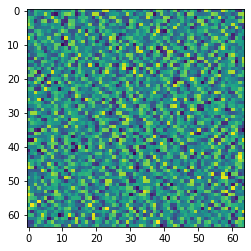

In [12]:
plt.imshow(nda[0,...,0])